### Online-News-Popularity
#### 預測網路新聞受歡迎程度

#### 1.定義 x , y
1. 解釋變數(X)
- 變數共有60個，其中有58個可預測特徵，2個不可預測特徵
- 移除URL和timedelta這兩個不可預測特徵
- 從相關係數圖可以看出**n_non_stop_unique_tokens**, **n_non_stop_words**, **kw_avg_min**這三個變數高度相關，所以也將這幾個變數移除
- 有離群值需處理

2. 反應變數(Y)
- 類別變數分三類（low, medium, high），分別表示新聞受歡迎程度

#### 2.preprocessing （缺失值/離群值/是否淘汰/合併變數）
- missing value
- 利用 Cox-Box來處理離群值
- - 將非正態分佈資料轉換為近似正態分佈的技術，可以處理資料的偏度和變異量，使資料更加符合模型的假設。
- 類別變數採1-of-C轉換以利分析
- 提取幾個自然語言處理特徵
- 對文本使用 LDA 算法(Latent Dirichlet Allocation)
- - LDA：每個文章都是由數個主題所主成；每個主題可以使用多個重要的words來描述，且相同的字可以出現在不同的主題
- 採用Pattern 網路挖掘模塊以方便計算情感急性(Polarity)的分數

#### 3.模型/呈現方法
1. 模型
- Baseline - Naive bayes
- KNN 
- Logistic Regression
- Random Forest
- gbdt
- xgboost


2. 呈現方法
- ROC曲線（曲線可能閾值：D2 ∈［0, 1]）
- Accuracy 
- Precision 
- Recall 
- F1 score （D2 = 0.5)
- AUC（為最相關的指標，理想為1.0 / 不理想為0.5）
- 滾動窗口分析，將L個舊樣本替換為新樣本

#### 4.分析結果
1. 以xgboost模型預測的結果最佳，AUC達到0.7095
2. 預測出三個對模型影響最重要的三個變數
- self_reference_avg_shares：提及的連結平均分享數。多個引用連結的平均分享數較高，比單一高分享數連結更具說服力。
- kw_avg_avg：一般關鍵字在含此關鍵字新聞中的平均分享數。平均分享數更能反映關鍵字在不同文章中的實際效果。
- LDA_00：以商業為主並涵蓋社交媒體的主題文章。商業新聞涉及實用信息，這些資訊直接影響決策，實用性強，分享率高。
3. 製作儀錶板，以方便觀測不同參數模型的表現




##### 載入資料

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv("D:/OneDrive/OneDrive - 國立臺北大學/NTPU/BDA/OnlineNewsPopularity.csv")

## 資料觀察

##### 觀察資料變數

In [7]:
print('資料維度：', df.shape) # 39644 為資料量，61為特徵數量

df_info = df.info() # 顯示資料型態

n = df.isna().sum() # 顯示缺失值
print('有遺失值的欄位：', n[n>0]) # 沒有遺失值

df_describe = df.describe() # 顯示個特徵的範圍、大小、波動趨勢等

資料維度： (39644, 61)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 61 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   url                             39644 non-null  object 
 1    timedelta                      39644 non-null  float64
 2    n_tokens_title                 39644 non-null  float64
 3    n_tokens_content               39644 non-null  float64
 4    n_unique_tokens                39644 non-null  float64
 5    n_non_stop_words               39644 non-null  float64
 6    n_non_stop_unique_tokens       39644 non-null  float64
 7    num_hrefs                      39644 non-null  float64
 8    num_self_hrefs                 39644 non-null  float64
 9    num_imgs                       39644 non-null  float64
 10   num_videos                     39644 non-null  float64
 11   average_token_length           39644 non-null  float64
 12   num_keywords 

##### 繪製各特徵的直方圖

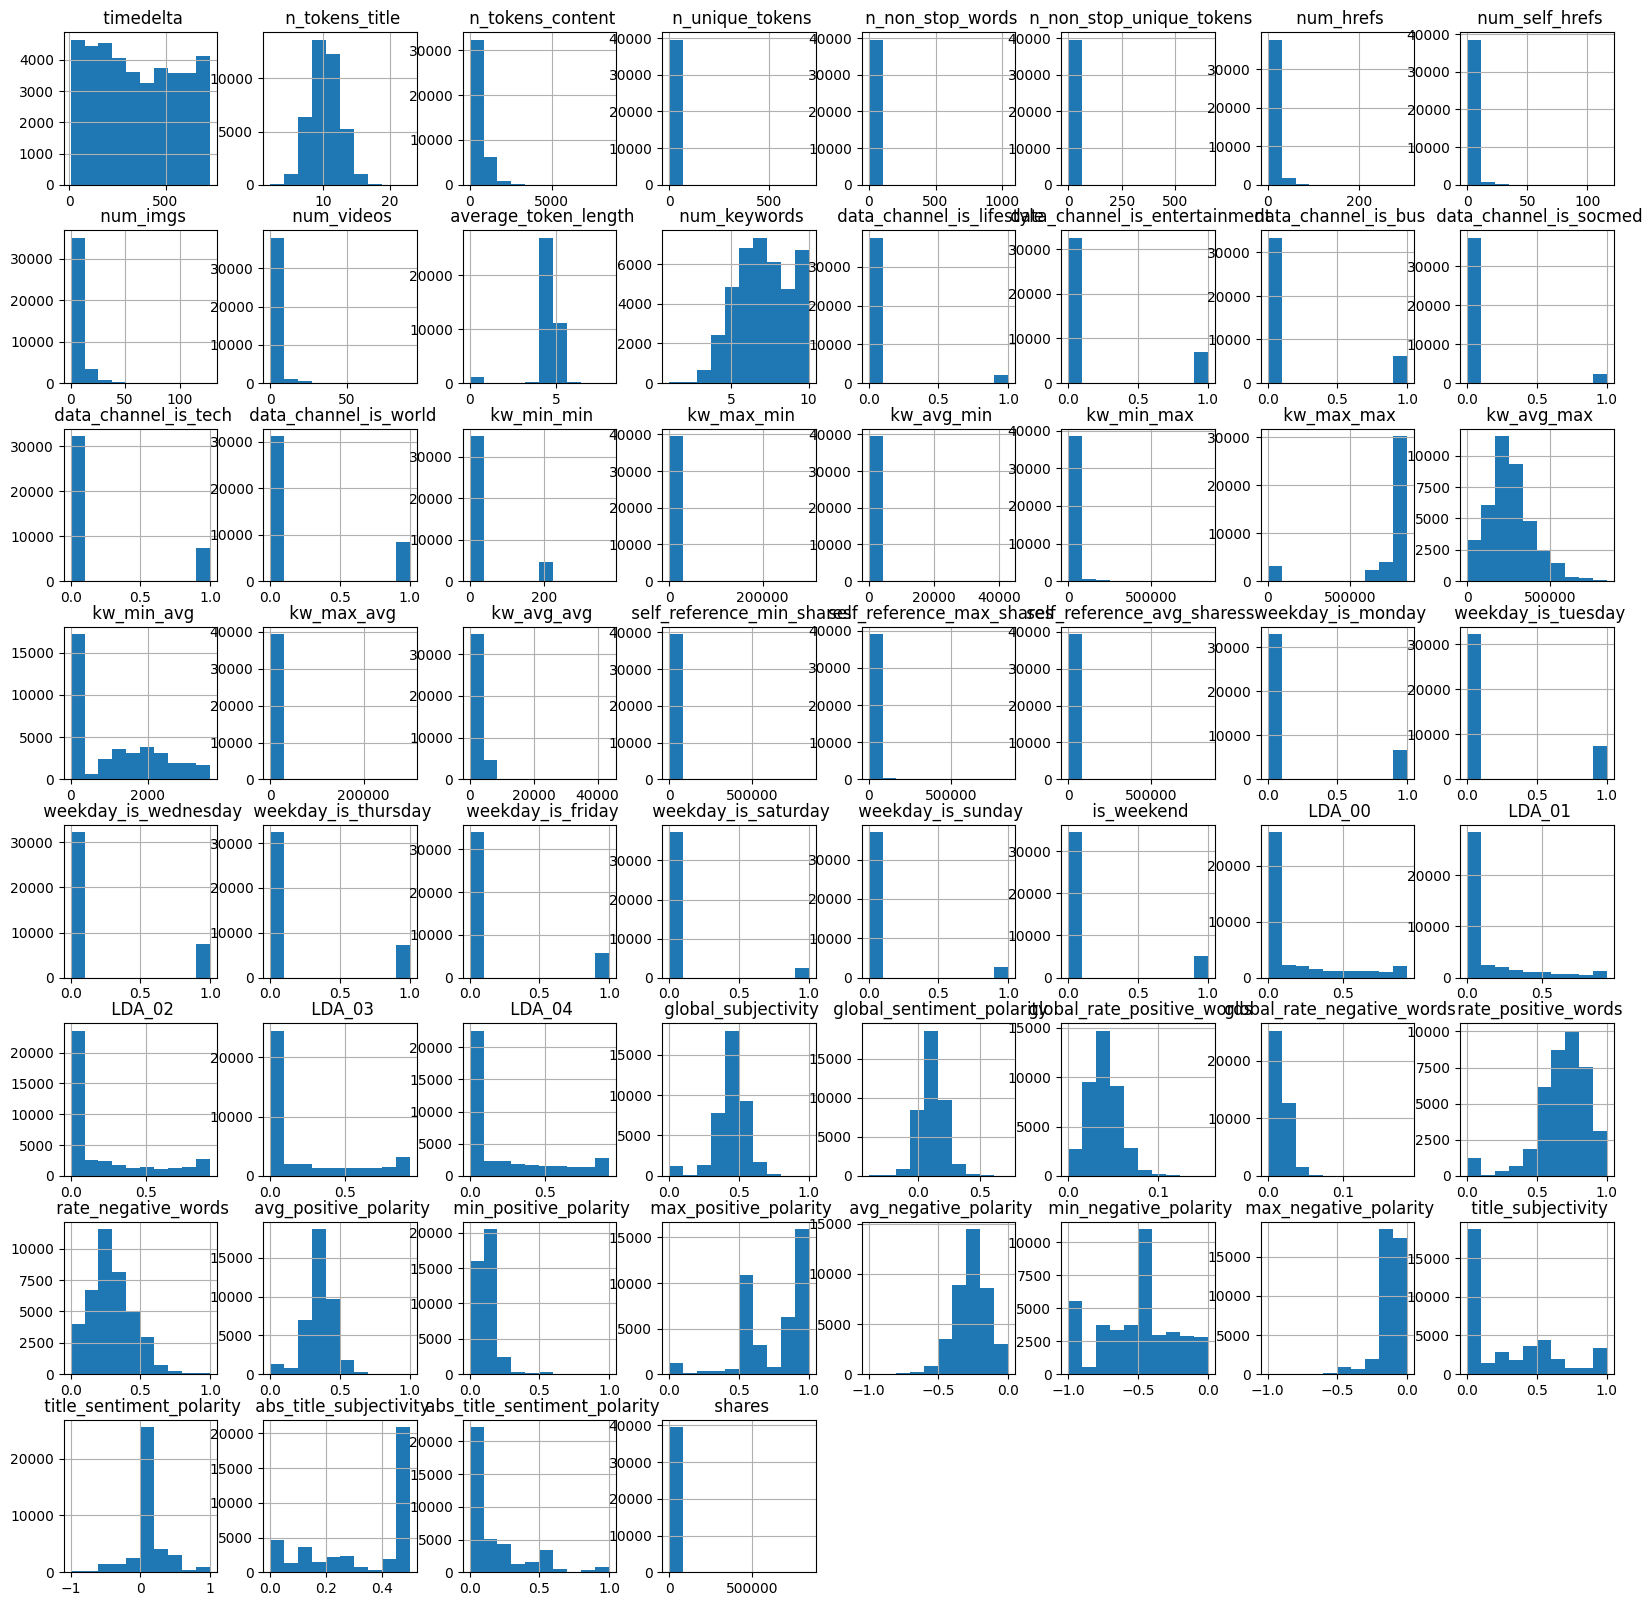

In [8]:
df.hist(figsize = (20, 20))
plt.title('Histograms of Numerical Columns', x=0.5, y=1.05, ha='center', fontsize=20)
plt.show() 

##### 移除特徵名稱中的空格

In [9]:
# Removing Space Character from Feature names
df.columns = df.columns.str.replace(" ","")

In [ ]:
# import seaborn as sns

# df_c_2 = df.iloc[:,1:]
# cor_2 = df_c_2.corr() # 計算相關係數
# plt.figure(figsize=(50,50))
# df_lt_2 = cor_2.where(np.tril(np.ones(cor_2.shape)).astype(bool)) # 只畫出對角線以下的相關係數
# sns.heatmap(df_lt_2, annot = True, cmap = 'Blues')

## 資料前處理

##### <font color = cyan> 不屬於任何頻道的文章數量（全部文章來看） </font>

In [10]:
df['data_channel'] = df[['data_channel_is_lifestyle', 'data_channel_is_entertainment', 'data_channel_is_bus',
                         'data_channel_is_socmed', 'data_channel_is_tech', 'data_channel_is_world']].sum(axis = 1)
df['data_channel'].value_counts()

data_channel
1.0    33510
0.0     6134
Name: count, dtype: int64

##### <font color = cyan> 全部文章中 kw_min_min 中 -1 的數量 </font>

In [11]:
# print kw_min_min 中 -1 的數量
print('kw_min_min 中 -1 的數量：', df['kw_min_min'][df['kw_min_min'] == -1].count())

kw_min_min 中 -1 的數量： 22980


##### <font color = lightgreen> 1. 將沒有內文的刪掉 </font>
##### <font color = lightgreen> 2. 分別新增沒有第一個和第二個特徵的連續型和類別型 dataframe </font>

In [12]:
# 去除沒有內文的
df_withcontent = df[df['n_tokens_content'] != 0]


# 去除第一個和第二個特徵
df_cont = df_withcontent.iloc[:, 2: -1] 
df_cate = df_withcontent.iloc[:, 2: -1]

# 只保留連續型的特徵（且沒有內文）
df_cont = df_cont.drop(["weekday_is_monday","weekday_is_tuesday","weekday_is_wednesday","weekday_is_thursday",
                        "weekday_is_friday","weekday_is_saturday","weekday_is_sunday","is_weekend",                  
                        "data_channel_is_lifestyle","data_channel_is_entertainment","data_channel_is_bus",
                        "data_channel_is_socmed","data_channel_is_tech","data_channel_is_world"], axis = 1)
# 只保留類別型的特徵（且沒有內文）
df_cate = df_cate[["weekday_is_monday","weekday_is_tuesday","weekday_is_wednesday","weekday_is_thursday",
                   "weekday_is_friday","weekday_is_saturday","weekday_is_sunday","is_weekend",            
                   "data_channel_is_lifestyle","data_channel_is_entertainment","data_channel_is_bus",
                  "data_channel_is_socmed","data_channel_is_tech","data_channel_is_world"]]



# print(df_cont.columns, df_cont.shape)
# print(df_cate.columns, df_cate.shape)
print(df_withcontent.columns)

Index(['url', 'timedelta', 'n_tokens_title', 'n_tokens_content',
       'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens',
       'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos',
       'average_token_length', 'num_keywords', 'data_channel_is_lifestyle',
       'data_channel_is_entertainment', 'data_channel_is_bus',
       'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_avg_min',
       'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg',
       'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares',
       'self_reference_avg_sharess', 'weekday_is_monday', 'weekday_is_tuesday',
       'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday',
       'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend', 'LDA_00',
       'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
     

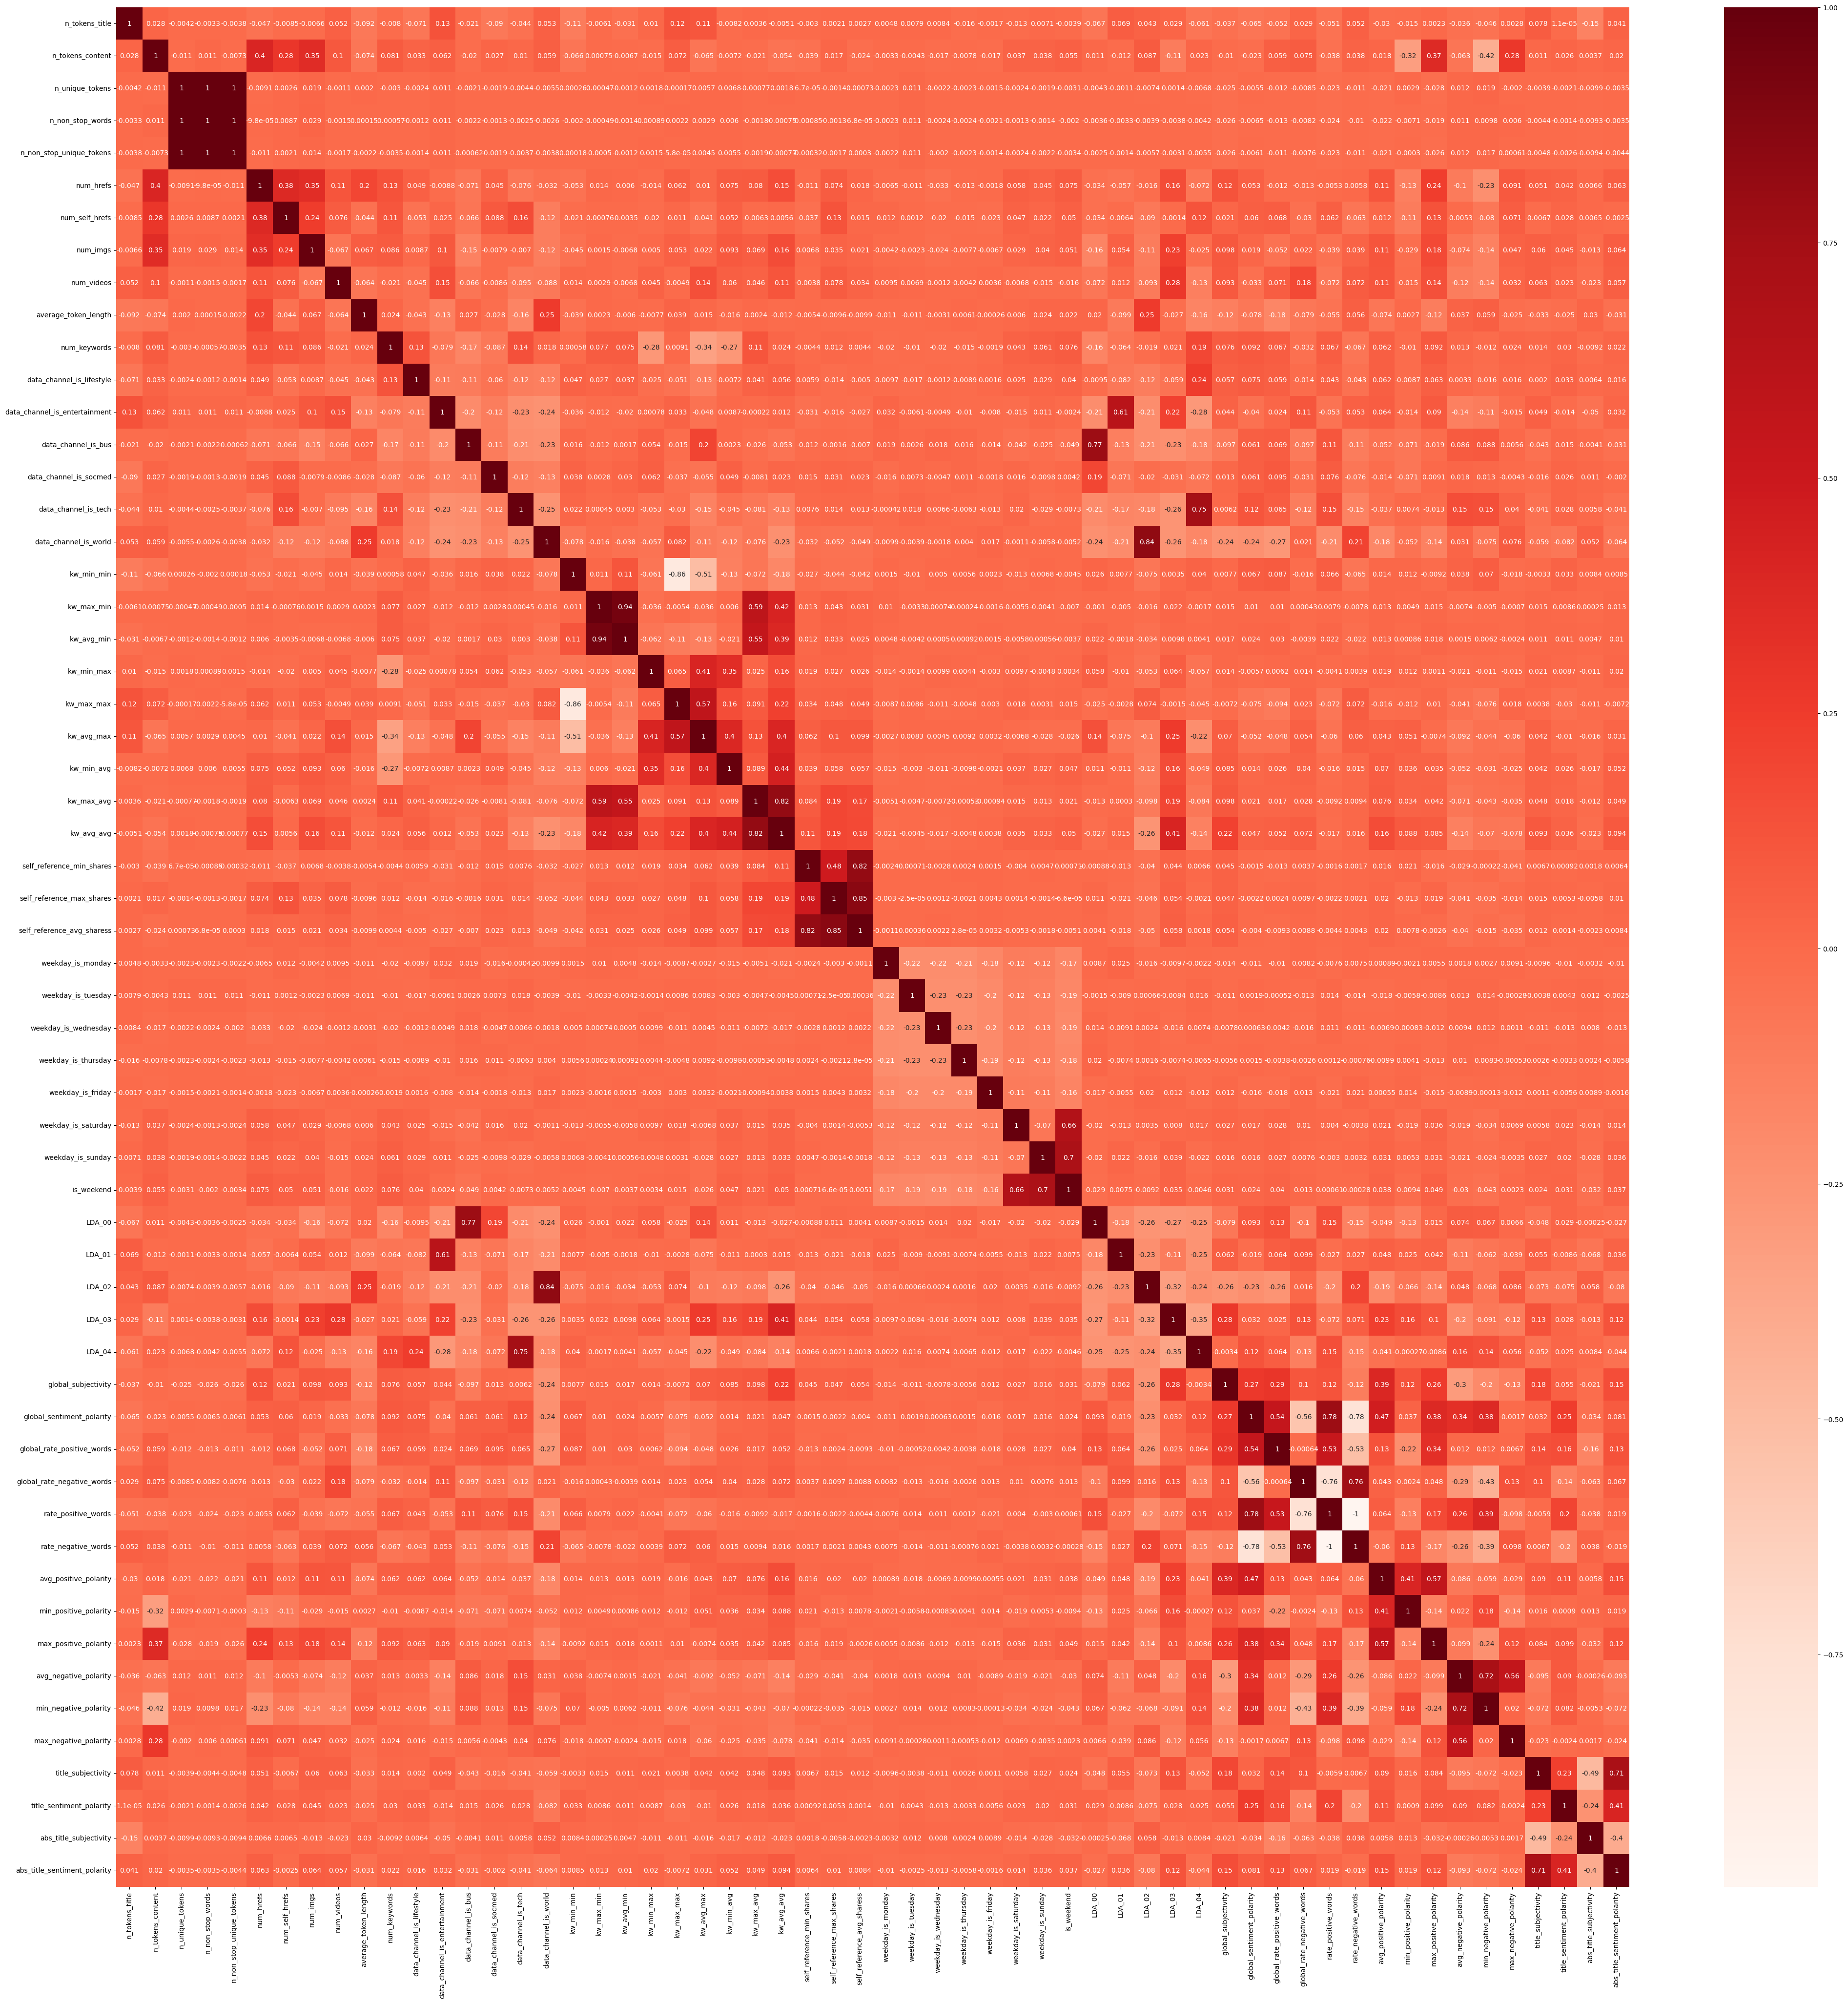

In [13]:
import seaborn as sns
# 相關係數圖
plt.figure(figsize=(50,50))
cor = df_withcontent.iloc[:, 2:-2].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [ ]:
# 做 Pearson Correlation test
from scipy.stats import pearsonr
corr, p_value = pearsonr(df_withcontent['n_unique_tokens'], df_withcontent['n_non_stop_words'])
print(corr, p_value)

corr, p_value = pearsonr(df_withcontent['n_unique_tokens'], df_withcontent['n_non_stop_unique_tokens'])
print(corr, p_value)

corr, p_value = pearsonr(df_withcontent['n_non_stop_words'], df_withcontent['n_non_stop_unique_tokens'])
print(corr, p_value)

0.9995899368988268 0.0
0.9998985434766945 0.0
0.9995382828579553 0.0


In [ ]:
df_withcontent

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares,data_channel
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,...,0.70,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593,1.0
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,...,0.70,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711,1.0
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,...,1.00,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500,1.0
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,...,0.80,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200,1.0
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,...,1.00,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39639,http://mashable.com/2014/12/27/samsung-app-aut...,8.0,11.0,346.0,0.529052,1.0,0.684783,9.0,7.0,1.0,...,0.75,-0.260000,-0.500,-0.125000,0.100000,0.000000,0.400000,0.000000,1800,1.0
39640,http://mashable.com/2014/12/27/seth-rogen-jame...,8.0,12.0,328.0,0.696296,1.0,0.885057,9.0,7.0,3.0,...,0.70,-0.211111,-0.400,-0.100000,0.300000,1.000000,0.200000,1.000000,1900,1.0
39641,http://mashable.com/2014/12/27/son-pays-off-mo...,8.0,10.0,442.0,0.516355,1.0,0.644128,24.0,1.0,12.0,...,0.50,-0.356439,-0.800,-0.166667,0.454545,0.136364,0.045455,0.136364,1900,0.0
39642,http://mashable.com/2014/12/27/ukraine-blasts/,8.0,6.0,682.0,0.539493,1.0,0.692661,10.0,1.0,1.0,...,0.50,-0.205246,-0.500,-0.012500,0.000000,0.000000,0.500000,0.000000,1100,1.0


##### <font color = cyan> 不屬於任何頻道的文章數量（有內文的文章來看） </font>

In [ ]:
df_withcontent.loc[:, 'data_channel'] = df_withcontent[['data_channel_is_lifestyle', 'data_channel_is_entertainment',
                                                 'data_channel_is_bus', 'data_channel_is_socmed',
                                                 'data_channel_is_tech', 'data_channel_is_world']].sum(axis = 1)
df_withcontent['data_channel'].value_counts()

data_channel
1.0    32972
0.0     5491
Name: count, dtype: int64

##### <font color = cyan> 有內文的文章中 kw_min_min 中 -1 的數量 </font>

In [ ]:
# print kw_min_min 中 -1 的數量
print('kw_min_min 中 -1 的數量：', df_withcontent['kw_min_min'][df_withcontent['kw_min_min'] == -1].count())

# print 出 kw_min_min 中每個數值相對應的數量
# print('kw_min_min 中每個數值相對應的數量：')
# print(df_withcontent['kw_min_min'].value_counts())
# 用dataframe的形勢來看
df_withcontent['kw_min_min'].value_counts().sort_index().to_frame()

kw_min_min 中 -1 的數量： 21914


,count
kw_min_min,
-1.0,21914
0.0,79
4.0,11832
41.0,1
42.0,1
45.0,2
47.0,6
57.0,5
63.0,2


##### <font color = lightgreen> 連續型變數的敘述性統計 </font>

In [ ]:
df_cont[:].describe()

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
count,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,...,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000
mean,10.382419,563.295375,0.565049,1.027065,0.710336,11.217872,3.394769,4.563061,1.263786,4.687892,...,0.098376,0.779963,-0.267493,-0.537970,-0.110801,0.280573,0.070997,0.342431,0.154930,3355.360398
std,2.113800,468.299538,3.573022,5.307978,3.312293,11.340580,3.869773,8.295365,4.164896,0.283231,...,0.070382,0.212509,0.121174,0.279703,0.094919,0.323561,0.264338,0.188606,0.225636,11585.968776
min,2.000000,18.000000,0.114964,1.000000,0.119134,0.000000,0.000000,0.000000,0.000000,3.600000,...,0.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,1.000000
25%,9.000000,259.000000,0.477419,1.000000,0.632588,5.000000,1.000000,1.000000,0.000000,4.496250,...,0.050000,0.600000,-0.331532,-0.714286,-0.125000,0.000000,0.000000,0.166667,0.000000,945.000000
50%,10.000000,423.000000,0.542986,1.000000,0.693727,8.000000,3.000000,1.000000,0.000000,4.674121,...,0.100000,0.800000,-0.257738,-0.500000,-0.100000,0.125000,0.000000,0.500000,0.000000,1400.000000
75%,12.000000,729.000000,0.611111,1.000000,0.756944,14.000000,4.000000,4.000000,1.000000,4.861901,...,0.100000,1.000000,-0.193415,-0.312500,-0.050000,0.500000,0.136364,0.500000,0.250000,2700.000000
max,23.000000,8474.000000,701.000000,1042.000000,650.000000,304.000000,116.000000,128.000000,91.000000,8.041534,...,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.500000,1.000000,843300.000000


##### <font color = lightgreen> 類別型變數的敘述性統計 </font>

In [ ]:
df_cate[:].describe()

,weekday_is_monday,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,weekday_is_friday,weekday_is_saturday,weekday_is_sunday,is_weekend,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world
count,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000
mean,0.168240,0.186439,0.187323,0.183345,0.143983,0.061592,0.069079,0.130671,0.054000,0.178249,0.162104,0.060084,0.190443,0.212360
std,0.374084,0.389466,0.390176,0.386954,0.351077,0.240416,0.253592,0.337045,0.226021,0.382727,0.368551,0.237645,0.392655,0.408984
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


##### <font color = lightgreen> 分出星期幾和哪種頻道的 df </font>

In [ ]:
df_weekdays = df_cate.columns[:7]
df_channels = df_cate.columns[8:]
print(len(df_weekdays), df_weekdays, sep = '\n')
print(len(df_channels), df_channels, sep = '\n')

7
Index(['weekday_is_monday', 'weekday_is_tuesday', 'weekday_is_wednesday',
       'weekday_is_thursday', 'weekday_is_friday', 'weekday_is_saturday',
       'weekday_is_sunday'],
      dtype='object')
6
Index(['data_channel_is_lifestyle', 'data_channel_is_entertainment',
       'data_channel_is_bus', 'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world'],
      dtype='object')


##### <font color = lightgreen> 新增一個可以判斷是星期幾的函數（可以回傳是 Monday、Tuesday、... 的函數）</font>

In [ ]:
def get_weekday(row):
    if row['weekday_is_monday'] == 1:
        return 'Monday'
    elif row['weekday_is_tuesday'] == 1:
        return 'Tuesday'
    elif row['weekday_is_wednesday'] == 1:
        return 'Wednesday'
    elif row['weekday_is_thursday'] == 1:
        return 'Thursday'
    elif row['weekday_is_friday'] == 1:
        return 'Friday'
    elif row['weekday_is_saturday'] == 1:
        return 'Saturday'
    elif row['weekday_is_sunday'] == 1:
        return 'Sunday'
    else:
        return 'None'

##### <font color = lightgreen> 新增一個可以判斷是甚麼頻道的函數（可以回傳是 'lifestyle', 'entertainment',..., 'None' 的函數）</font>

In [ ]:
def get_channel(row):
    if row['data_channel_is_lifestyle'] == 1:
        return 'lifestyle'
    elif row['data_channel_is_entertainment'] == 1:
        return 'entertainment'
    elif row['data_channel_is_bus'] == 1:
        return 'business'
    elif row['data_channel_is_socmed'] == 1:
        return 'socmed'
    elif row['data_channel_is_tech'] == 1:
        return 'tech'
    elif row['data_channel_is_world'] == 1:
        return 'world'
    else:
        return 'None'

##### <font color = lightgreen> 在 df_withcontent 新增新的一個變數 "**weekday**"，可以看到樣本是 Monday、Tuesday、... </font>

In [ ]:
# df_withcontent['weekday'] = df_withcontent.apply(get_weekday, axis = 1)
df_withcontent.loc[:, 'weekday'] = df_withcontent.apply(get_weekday, axis=1)

C:\Users\USER\AppData\Local\Temp\ipykernel_14248\428268832.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_withcontent.loc[:, 'weekday'] = df_withcontent.apply(get_weekday, axis=1)


##### <font color = lightgreen> 在 df_withcontent 新增新的一個變數 "**channel**"，可以看到樣本是 lifestyle、entertainment、...、None </font>

In [ ]:
# df_withcontent['weekday'] = df_withcontent.apply(get_weekday, axis = 1)
df_withcontent.loc[:, 'channel'] = df_withcontent.apply(get_channel, axis=1)

C:\Users\USER\AppData\Local\Temp\ipykernel_14248\3636079198.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_withcontent.loc[:, 'channel'] = df_withcontent.apply(get_channel, axis=1)


##### <font color = lightgreen> 在 df_withcontent 新增一個變數"share_2_ca"，如果 shares <= 2000 則值為 0；若 shares > 2000 則值為 1 </font>

In [ ]:
# df_withcontent['share_2_ca'] = df_withcontent['shares'].apply(lambda x: 0 if x <= 2000 else 1)
df_withcontent.loc[:, 'share_2_ca'] = df_withcontent['shares'].apply(lambda x: 0 if x <= 2000 else 1)


C:\Users\USER\AppData\Local\Temp\ipykernel_14248\3079804477.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_withcontent.loc[:, 'share_2_ca'] = df_withcontent['shares'].apply(lambda x: 0 if x <= 2000 else 1)


##### <font color = lightgreen> 建立一個列聯表 "**weekday_tab**" 以觀察星期幾所對應的 shares 數量有沒有超過 2000 </font>

In [ ]:
# 將星期幾的欄位轉換為類別型別，並指定排序順序
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_withcontent.loc[:, 'weekday'] = pd.Categorical(df_withcontent['weekday'], categories=weekday_order, ordered=True)

# 建立交叉表
weekday_tab = pd.crosstab(df_withcontent['share_2_ca'], df_withcontent['weekday'], margins=False)
weekday_tab

weekday,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
share_2_ca,,,,,,,
0,3606,4360,1199,1451,4794,4949,4972
1,1932,2111,1170,1206,2258,2222,2233


In [ ]:
channel_tab = pd.crosstab(df_withcontent['share_2_ca'], df_withcontent['channel'], margins = False)
channel_tab

channel,None,business,entertainment,lifestyle,socmed,tech,world
share_2_ca,,,,,,,
0,2876,4238,5093,1246,1111,4358,6409
1,2615,1997,1763,831,1200,2967,1759


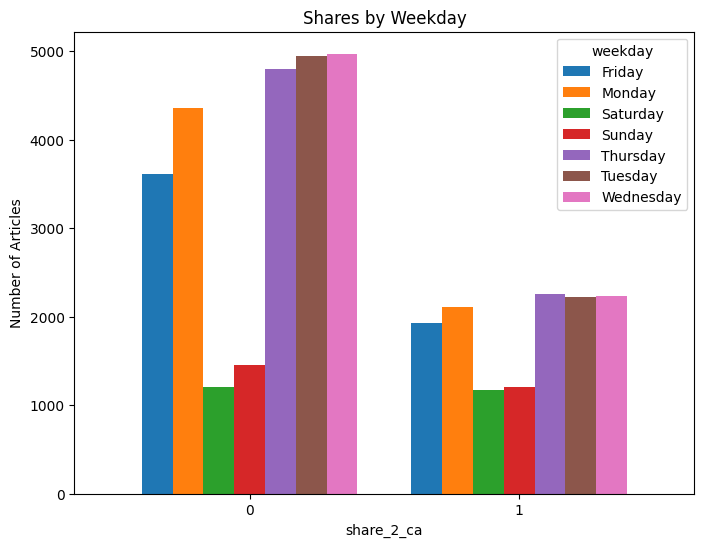

In [ ]:
# 畫出交叉表，但不要堆疊
weekday_tab.plot(kind='bar', width = 0.8, stacked=False, figsize=(8, 6))
plt.title('Shares by Weekday')
plt.ylabel('Number of Articles')
plt.xlabel('share_2_ca')
plt.xticks(rotation=0)
plt.show()

##### <font color = lightgreen> 做卡方檢定看 shares 和 星期幾是否有關 </font>

In [ ]:
from scipy.stats import chi2_contingency

chi2_stat, p_val, dof, expected = chi2_contingency(weekday_tab)

# 打印結果
print("Chi-square statistic:", chi2_stat)

if p_val < 0.05:
    print("p-value = ", {p_val}, "小於 0.05。拒絕原假設。變數之間存在顯著關聯。")
else:
    print("p-value = ", {p_val}," 大於或等於 0.05。無法拒絕原假設。變數之間不存在顯著關聯。")

print("Degrees of freedom:", dof)
print("Expected frequencies table:")
print(expected)


Chi-square statistic: 480.07767498977455
p-value =  {1.642891796268445e-100} 小於 0.05。拒絕原假設。變數之間存在顯著關聯。
Degrees of freedom: 6
Expected frequencies table:
[[3647.22143359 4261.67748226 1560.17832722 1749.84964771 4644.3130281
  4722.684164   4745.07591712]
 [1890.77856641 2209.32251774  808.82167278  907.15035229 2407.6869719
  2448.315836   2459.92408288]]


##### <font color = lightgreen> 做卡方檢定看 shares 和 頻道是否有關 </font>

In [ ]:
from scipy.stats import chi2_contingency

chi2_stat, p_val, dof, expected = chi2_contingency(channel_tab)

# 打印結果
print("Chi-square statistic:", chi2_stat)
print("p-value:", p_val)
print("Degrees of freedom:", dof)
print("Expected frequencies table:")
print(expected)

Chi-square statistic: 1738.8434917774662
p-value: 0.0
Degrees of freedom: 6
Expected frequencies table:
[[3616.26812781 4106.25237241 4515.23115722 1367.87268284 1521.98063074
  4824.10563399 5379.289395  ]
 [1874.73187219 2128.74762759 2340.76884278  709.12731716  789.01936926
  2500.89436601 2788.710605  ]]


##### <font color = lightgreen> 畫圖分別看星期一 ~ 星期日的分享數 <2000 的和 >2000 的 shares 數量 </font>

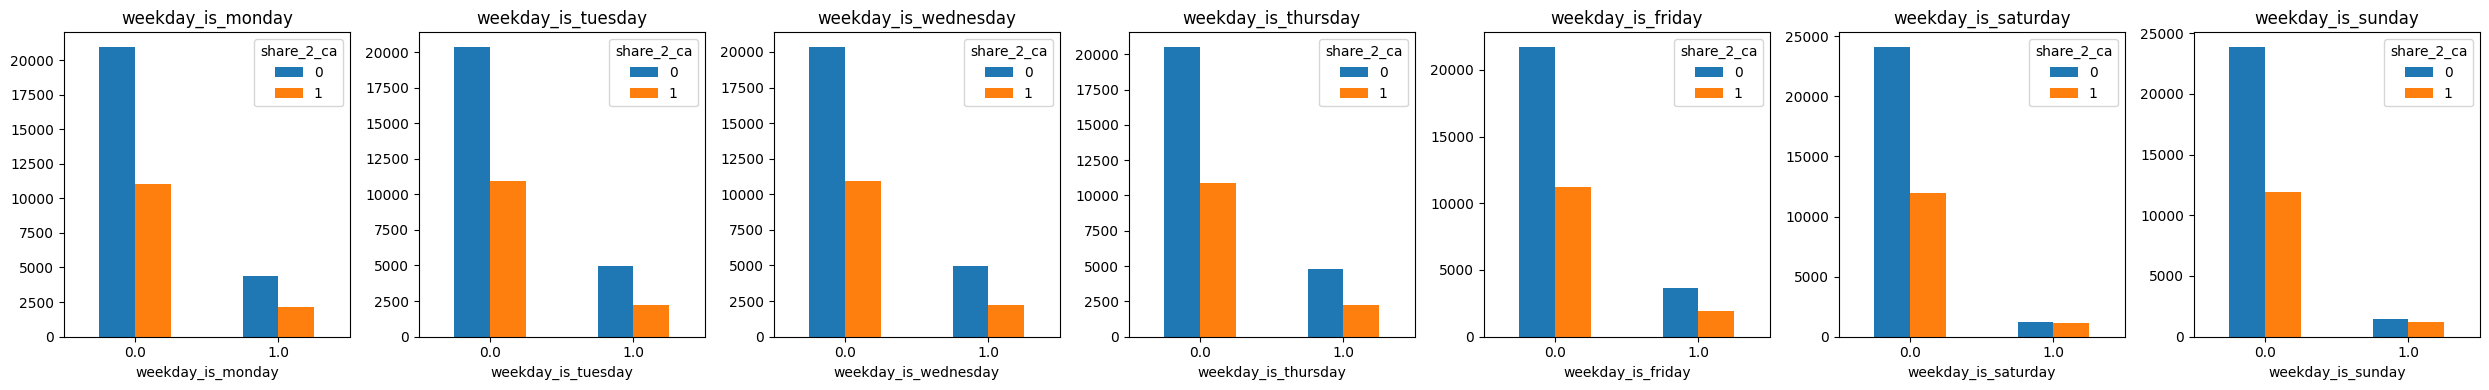

In [ ]:
import matplotlib.pyplot as plt

col_list = ['weekday_is_monday', 'weekday_is_tuesday', 'weekday_is_wednesday',
            'weekday_is_thursday', 'weekday_is_friday', 'weekday_is_saturday', 'weekday_is_sunday']

fig, ax = plt.subplots(1, 7, figsize=(25, 4))
for i, cat_var in enumerate(col_list):
    # 生成列聯表
    crosstab = pd.crosstab(df_withcontent[cat_var], df_withcontent['share_2_ca'])
    
    # 繪製長條圖
    crosstab.plot(kind='bar', ax=ax[i])
    ax[i].set_title(cat_var)
    ax[i].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()


##### <font color = lightgreen> 畫圖分別看不同頻道的分享數 <2000 的和 >2000 的 shares 數量 </font>

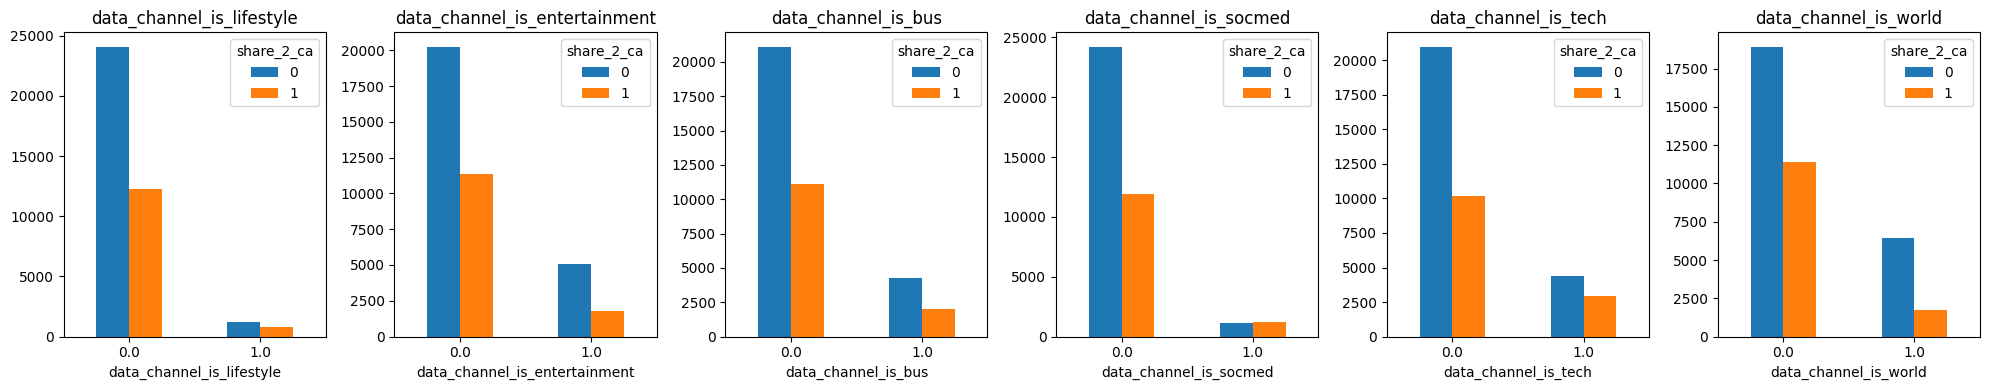

In [ ]:
import matplotlib.pyplot as plt

col_list2 = ['data_channel_is_lifestyle', 'data_channel_is_entertainment', 'data_channel_is_bus',
             'data_channel_is_socmed', 'data_channel_is_tech', 'data_channel_is_world']

fig, ax = plt.subplots(1, 6, figsize=(20, 4))
for i, cat_var in enumerate(col_list2):
    # 生成列聯表
    crosstab = pd.crosstab(df_withcontent[cat_var], df_withcontent['share_2_ca'])
    
    # 繪製長條圖
    crosstab.plot(kind='bar', ax=ax[i])
    ax[i].set_title(cat_var)
    ax[i].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()


##### <font color = lightgreen> 計算出每個lda所隸屬的頻道總數 </font>

In [ ]:
col_cha = ['data_channel_is_lifestyle', 'data_channel_is_entertainment', 'data_channel_is_bus',
           'data_channel_is_socmed', 'data_channel_is_tech', 'data_channel_is_world']
c = 0.3
lda0_df = df_withcontent[df_withcontent['LDA_00'] >= c]
lda1_df = df_withcontent[df_withcontent['LDA_01'] >= c]
lda2_df = df_withcontent[df_withcontent['LDA_02'] >= c]
lda3_df = df_withcontent[df_withcontent['LDA_03'] >= c]
lda4_df = df_withcontent[df_withcontent['LDA_04'] >= c]

def calculate_channel_times(df, col_cha):
    channel_times = []
    for col in col_cha:
        num = int(df[col].sum())
        channel_times.append(num)
    channel_times_df = pd.DataFrame(data=[channel_times], columns=col_cha)
    return channel_times_df

dfs = {'lda0': lda0_df, 'lda1': lda1_df, 'lda2': lda2_df, 'lda3': lda3_df, 'lda4': lda4_df}
lda_df = pd.DataFrame()
for df_name, df in dfs.items():
    lda_n_df = calculate_channel_times(df, col_cha)
    lda_n_df.index = [df_name]
    lda_df = pd.concat([lda_df, lda_n_df], axis=0)

new_columns = ['life','entertain','busi','socmed','tech','world']
lda_df.columns = new_columns
print(pd.DataFrame(lda_df))


      life  entertain  busi  socmed  tech  world
lda0   457        252  5787    1376   448    376
lda1   102       4209   327     140   366    210
lda2   124        641   404     563   872   7592
lda3   381       3145   264     504   298    458
lda4  1598        302   868     412  7042   1336


In [ ]:
print(100 * 58 + 500 * 34 + 1000 * 35)
print(3648 + 2500)

57800
6148


##### 找出沒有內文的文章數量，並保留有內文的文章
- 可能有幾篇文章的 n_tokens_contents 單字數量為 0，但這些文章對分析沒有意義

In [ ]:
num_of_nowords = df[df['n_tokens_content']==0].index # 此為沒有內容的文章
print('沒有內文的文章index:', num_of_nowords)
print('沒有內文的文章數量:', num_of_nowords.size) 
# 共有1181篇文章沒有內文
df_withcontent2 = df[df['n_tokens_content'] != 0] # 只保留有內文的文章

沒有內文的文章index: Index([], dtype='int64')
沒有內文的文章數量: 0


<hr>

##### 刪除不必要的特徵
1. URL 這行特徵為非數值的特徵，因此要將其移除

2. timedelta 這行特徵為非預測性的特徵，也不是這個資料的特徵之一，因此也將其移除

3. 因為 **n_non_stop_unique_tokens**, **n_non_stop_words**, **kw_avg_min**這三個特徵高度相關，因此也將他們移除

In [ ]:
df_selectvariable = df_withcontent2.drop( 'url', axis = 1 )
df_selectvariable = df_selectvariable.drop( 'timedelta', axis = 1 )
df_selectvariable = df_selectvariable.drop( [ "n_non_stop_unique_tokens",
                                              "n_non_stop_words",
                                              "kw_avg_min" ], axis = 1
                                            )

##### 觀察反應變數的相關統計量

- 可以看到中位數是1400，平均值是3355.36，右偏（少數有幾筆資料的shares數量很大）

In [ ]:
df_selectvariable[:].describe()

In [ ]:
df[:].describe()

##### 找出類別的特徵（這段好像沒什麼用）

In [ ]:
Wday = df_selectvariable.columns.values[26:33] # 星期幾的欄位
print(Wday)
Dc = df_selectvariable.columns[9:15] # 文章分類的欄位
print(Dc)

## 設定反應變數的分類

##### 新增新的反應變數以觀察受歡迎程度（分五個或三個）

In [ ]:
import seaborn as sns
conditions_5 = [
    (df_selectvariable['shares'] < 650),
    (df_selectvariable['shares'] < 1000), 
    (df_selectvariable['shares'] < 4000),
    (df_selectvariable['shares'] < 50000),
    (df_selectvariable['shares'] < 943300)
    ]
conditions_3 = [
    (df_selectvariable['shares'] < 1000), 
    (df_selectvariable['shares'] < 4000),
    (df_selectvariable['shares'] < 943300)
    ]

values_5 = ['very_low','low','medium','high', 'very_high']
values_3 = ['low','medium','high']

df_selectvariable['shares_5_cat'] = np.select(conditions_5, values_5)
df_selectvariable['shares_3_cat'] = np.select(conditions_3, values_3)

# df_selectvariable['popularity'] = df_selectvariable['shares'].apply(lambda x: 0 if x <1400 else 1)

sns.set_theme(rc = {'figure.figsize':(9,6)})
ax = sns.countplot(x = df_selectvariable['shares_5_cat'])
ax.set(xlabel = 'Article Popularity Flag', ylabel = 'Number of Examples by Popularity')
plt.title('Number of examples in each class')
plt.show()

sns.set_theme(rc = {'figure.figsize':(9,6)})
ax = sns.countplot(x = df_selectvariable['shares_3_cat'])
ax.set(xlabel = 'Article Popularity Flag', ylabel = 'Number of Examples by Popularity')
plt.title('Number of examples in each class')
plt.show()

## 離群值的處理

##### 繪製各特徵的盒鬚圖觀察

In [ ]:
# df_selectvariable 在這裡另外取名為 df_ 不然太長了
df_ = df_selectvariable
num_cols = df_.select_dtypes(['int64','float64']).columns # 數值型的特徵
print(len(num_cols))
fig, axes = plt.subplots(7, 8, figsize=(20, 20))
for i, ax in enumerate(axes.flatten()):
    if i < len(num_cols):
        sns.boxplot(x = df_[num_cols[i]], ax = ax)
plt.tight_layout()
plt.show()

##### 觀察每個特徵的離群值數量和相關資訊

In [ ]:
columns = []; outliers = []; proportion = []; llimit = []; ulimit = []; IQR = []
# 將各欄位的離群值數量、下限、上限、四分位距存入上述陣列
for column in num_cols:    
    q1 = df_[column].quantile(0.25)    # First Quartile
    q3 = df_[column].quantile(0.75)    # Third Quartile
    IQR_ = q3 - q1   # Inter Quartile Range

    llimit_ = q1 - 1.5*IQR_   # Lower Limit
    ulimit_ = q3 + 1.5*IQR_   # Upper Limit

    outliers_ = df_[(df_[column] < llimit_) | (df_[column] > ulimit_)] # 離群值
    columns.append(column)
    outliers.append(len(outliers_)) # 離群值的數量
    proportion.append(len(outliers_)/len(df_)) # 離群值的比例
    llimit.append(llimit_)
    ulimit.append(ulimit_)
    IQR.append(IQR_)
    
# 將上述陣列轉換為dataframe
outliers_df = pd.DataFrame({'特徵名稱':columns,
                            '離群值數量':outliers,
                            '所占比例':['{:.2%}'.format(p) for p in proportion],
                            '下界':[round(l, 4) for l in llimit],
                            '上界':[round(l, 4) for l in ulimit],
                            '四分位數':[round(l, 4) for l in IQR]})
outliers_df

##### 重新調整資料的縮放程度（scaling）

1. 創建 df2_num 以去除類別變數和反應變數

2. 創建 df2_cat 以包含類別變數

In [ ]:
df2_num = df_.drop(["weekday_is_monday","weekday_is_tuesday","weekday_is_wednesday","weekday_is_thursday",
                  "weekday_is_friday","weekday_is_saturday","weekday_is_sunday","is_weekend",                  
                  "data_channel_is_lifestyle","data_channel_is_entertainment","data_channel_is_bus",
                  "data_channel_is_socmed","data_channel_is_tech","data_channel_is_world",
                  'shares', 'shares_3_cat', 'shares_5_cat'],axis=1)
df2_cat = df_[["weekday_is_monday","weekday_is_tuesday","weekday_is_wednesday","weekday_is_thursday",
             "weekday_is_friday","weekday_is_saturday","weekday_is_sunday","is_weekend",            
             "data_channel_is_lifestyle","data_channel_is_entertainment","data_channel_is_bus",
                  "data_channel_is_socmed","data_channel_is_tech","data_channel_is_world"]]
df2_num.columns

##### 找出有負值的欄位，以利後續進行 box-cox 的處理

In [ ]:
negcols = df2_num.columns[(df2_num <= 0).any()] # 有負值的欄位
# negcols

# 以 dataframe 的方式顯示「有負值的欄位」並計算「每個欄位的負值數量」
neg_count = []
for column in negcols:
    neg_count_ = len(df2_num[df2_num[column] <= 0])
    neg_count.append(neg_count_)
neg_df = pd.DataFrame({'特徵名稱':negcols, '負值（包含 0）數量':neg_count})
neg_df

##### 將負值轉換為正值（因為該筆資料為非常態且有負值）

In [ ]:
df2_num_withnew = df2_num.copy() # 複製一份 df2_num 以存放處理為正值的資料
for i in negcols:
    m = df2_num_withnew[i].min()
    name = i +'_new'
    df2_num_withnew[name] = ((df2_num_withnew[i] + 1) - m)
df2_num_withnew

##### 將原本有負值的欄位刪除，並確認是否還有負值，以利進行 box-cox 轉換（資料需為正數）

In [ ]:
# 複製df2_num_withnew的資料到df2_num_nonneg，以存放刪除有負值的欄位後的資料
df2_num_nonneg = df2_num_withnew.copy()
for i in negcols:
    df2_num_nonneg.drop(i, axis=1, inplace=True) # 將原本有負值的欄位刪除（有負值的那些就留下後面有 new 的）

# negcols=df2_num.columns[(df2_num<=0).any()] # 確認是否還有負值
# negcols
# 印出刪除前的shape和刪除後的shape
print('原始數值型特徵的資料維度 =', df2_num.shape) # 61 - 3 - 14 - 3（前面刪掉但好像不該刪的那 3 個特徵） = 41
print('包含為了處理負值的特徵而新建的特徵的資料維度 =', df2_num_withnew.shape) # 多 36 個
print('刪除仍有負值的特徵後的資料維度 =', df2_num_nonneg.shape)
# 因原本有36個特徵有包含負值，經過前面處理，並為那些有負值的特徵創建一個新的特徵（後面會加_new），總共 36 個

##### 使用 preprocessing.PowerTransformer 來對資料進行「Box-Cox」變換

- 將非常態分佈資料轉換為近似常態分佈的技術，可以處理資料的偏度和變異量，使資料更加符合模型的假設

In [ ]:
from sklearn import preprocessing
pt = preprocessing.PowerTransformer(method='box-cox', standardize = False)   # standardize = False 表示不對資料進行標準化
df2_num_add = pt.fit_transform(df2_num_nonneg)   # 使用 fit_transform() 方法將 Box-Cox 變換應用於數據集 df2_num 上，將轉換後的結果存儲在 df2_num_add 中
df2_num_add = (pd.DataFrame(df2_num_add, columns = df2_num_nonneg.columns))
# df2_num_add 為透過box-cox轉換後的數值型特徵

##### 將超出 1% 和 99% 百分位數範圍的值替換為相應的百分位數值。（結尾處理 Trimming）

- 目的為移除極端值，使數據更加穩定，以防止它們對模型造成不利影響。

In [ ]:
for col in df2_num_add.columns:
    percentiles = df2_num_add[col].quantile([0.01,0.99]).values           # 取得 1% 和 99% 的分位數 （上下界）
    df2_num_add[col][df2_num_add[col] <= percentiles[0]] = percentiles[0] # 如果該數值 <= 第1百分位數（該數據的最小值），則將該數值替換為第1百分位數，以進行下界截尾。
    df2_num_add[col][df2_num_add[col] >= percentiles[1]] = percentiles[1] # 如果該數值 >= 第99百分位數（即該數據的最大值），則將該數值替換為第99百分位數，以進行上界截尾。

##### 確認處理完之後的離群值數量及其相關資訊

In [ ]:
num_cols_2 = df2_num_add.select_dtypes(['int64','float64']).columns
print(len(num_cols_2))
print(num_cols_2)

In [ ]:
num_cols_2 = df2_num_add.select_dtypes(['int64','float64']).columns

columns_2 = []; outliers_2 = []; proportion_2 = []; llimit_2 = []; ulimit_2 = []; IQR_2 = []
# 將各欄位的離群值數量、下限、上限、四分位距存入上述陣列
for column in num_cols_2:    
    q1 = df2_num_add[column].quantile(0.25)    # First Quartile
    q3 = df2_num_add[column].quantile(0.75)    # Third Quartile
    IQR_ = q3 - q1                            # Inter Quartile Range

    llimit_ = q1 - 1.5*IQR_                       # Lower Limit
    ulimit_ = q3 + 1.5*IQR_                        # Upper Limit

    outliers_ = df2_num_add[(df2_num_add[column] < llimit_) | (df2_num_add[column] > ulimit_)] # 離群值
    columns_2.append(column)
    outliers_2.append(len(outliers_)) # 離群值的數量
    proportion_2.append(len(outliers_)/len(df2_num_add)) # 離群值的比例
    llimit_2.append(llimit_)
    ulimit_2.append(ulimit_)
    IQR_2.append(IQR_)

outliers_df_2 = pd.DataFrame({'特徵':columns_2,
                              '離群值數量':outliers_2,
                              '所占比例':['{:.2%}'.format(p) for p in proportion_2],
                              '下界':[round(l, 4) for l in llimit_2],
                              '上界':[round(l, 4) for l in ulimit_2],
                              '四分位數':[round(l, 4) for l in IQR_2]}
                              )
outliers_df_2

##### 繪製處理前的連續型特徵盒鬚圖

In [ ]:
num_cols = df2_num.select_dtypes(['int64','float64']).columns # 數值型的特徵
fig, axes = plt.subplots(5, 10, figsize=(36, 18)) # 共 41 個
# 繪製箱型圖，並讓讓每個特徵的離群值以紅色標示
for i, ax in enumerate(axes.flatten()):
    if i < len(num_cols):
        # sns.boxplot(x = df2_num[num_cols[i]], ax = ax)
        sns.boxplot(x = df2_num[num_cols[i]], ax = ax, flierprops = dict(marker = 'o', markerfacecolor = 'red', markersize = 8))
# plt.tight_layout()
plt.show()

##### 繪製處理前的類別型特徵直方圖

In [ ]:
fig, axes = plt.subplots(2, 7, figsize=(30, 8))

for i, ax in enumerate(axes.flatten()):
    if i < len(df2_cat.columns):
        df2_cat[df2_cat.columns[i]].hist(ax=ax)
        ax.set_title(df2_cat.columns[i], x=0.5, y=-0.2, ha='center')

plt.show()




# 繪製每個類別型特徵的長條圖
fig, axes = plt.subplots(2, 7, figsize=(30, 8))

for i, ax in enumerate(axes.flatten()):
    if i < len(df2_cat.columns):
        sns.countplot(x = df2_cat[df2_cat.columns[i]], ax = ax)
        ax.set_title(df2_cat.columns[i], x=0.5, y=-0.2, ha='center')

plt.show()

##### 繪製每個類別型特徵的圓餅圖

In [ ]:
fig, axes = plt.subplots(2, 7, figsize=(15, 5))

for i, ax in enumerate(axes.flatten()):
    if i < len(df2_cat.columns):
        counts = df2_cat[df2_cat.columns[i]].value_counts() # 計算每個類別的數量
        labels = counts.index # 類別
        sizes = counts.values # 數量
        
        ax.pie(sizes, labels = labels, autopct = '%1.1f%%', startangle = 140, colors = ['pink', 'lightsteelblue'])
        ax.set_title(df2_cat.columns[i], x=0.5, y=-0.2, ha='center')

plt.tight_layout()
plt.show()

##### 再次觀察經過負值處理轉正、box-cox轉換、結尾處理之後的盒鬚圖

In [ ]:
fig, axes = plt.subplots(7, 6, figsize=(20, 20))
for i, ax in enumerate(axes.flatten()):
    if i < len(num_cols_2):
        sns.boxplot(x = df2_num_add[num_cols_2[i]], ax = ax)
plt.tight_layout()
plt.show()

##### combine 類別特徵和數值型特徵

In [ ]:
print(df2_num_add.columns.size) # 透過box-cox轉換後的數值型特徵的數量
print(df2_cat.columns.size) # 類別型特徵的數量
print(df2_num_add.shape) # 透過box-cox轉換後的數值型特徵的資料維度
print(df2_cat.shape) # 類別型特徵的資料維度

In [ ]:
df_final = pd.concat([df2_num_add,df2_cat],axis=1)
print('目前資料的維度：', df_final.shape)
# 39518 為目前的資料量，41 + 14 = 55為目前的特徵數量

##### 確認遺失值的數量

In [ ]:
df_final.isnull().sum() # 確認各特徵遺失值的數量
# print(df_final.isnull().sum())


missing_values = pd.DataFrame(df_final.isnull().sum(), columns = ['missing_values'])
missing_values['features'] = missing_values.index
missing_values = missing_values.reset_index(drop=True)
missing_values = missing_values[['features', 'missing_values']]
missing_values = missing_values[missing_values['missing_values'] > 0]
missing_values

# 會有遺失值的原因是因為有些特徵是類別型特徵，而我們在進行 One-Hot Encoding 時，會將類別型特徵轉換為多個二元特徵，因此會有遺失值
# One-Hot Encoding 旨在將類別型特徵轉換為數值型特徵，以便模型能夠理解這些特徵
# 1055 是因為 weekday_is_saturday 和 weekday_is_sunday 這兩個特徵都是 0，因此在進行 One-Hot Encoding 時，會有遺失值

##### 將有遺失值的資料刪除

In [ ]:
df_final_2 = df_final.dropna() # 刪除遺失值
print('未刪除前的資料維度：', df_final.shape)
print('刪除後的資料維度：', df_final_2.shape)
# 39518 - 1055*2 = 37408
# 37408 為目前的資料量，55 為目前的特徵數量

<hr>

## 機器學習的模型選擇

1. Model-1: Baseline - Naive bayes

2. Model-2: KNN

3. Model-3: Logistic Regression

4. Model-4: Random Forest

5. Model-5: gbdt

6. Model-6: xgboost

##### <font color = lightgreen> 建立一個只有連續型變數和去掉一些相關性很高的變數的 df "**clean_df**" </font>

In [ ]:
clean_df = df_withcontent.drop(columns = ['data_channel_is_entertainment', 'data_channel_is_bus', 'data_channel_is_socmed',
                                          'data_channel_is_tech', 'data_channel_is_world', 'data_channel_is_lifestyle',
                                          'weekday_is_monday', 'weekday_is_tuesday', 'weekday_is_wednesday', 'weekday_is_thursday',
                                          'weekday_is_friday', 'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend'])

useless_col = ['url', 'timedelta', 'n_non_stop_words', 'n_unique_tokens', 'rate_negative_words', 'kw_max_min', 'self_reference_min_shares', 'self_reference_max_shares']
clean_df = clean_df.drop(columns = useless_col)

clean_df = clean_df.drop(columns = ['data_channel', 'channel' ,  'weekday'])

clean_df.head()

,n_tokens_title,n_tokens_content,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,kw_min_min,...,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares,share_2_ca
0,12.0,219.0,0.815385,4.0,2.0,1.0,0.0,4.680365,5.0,0.0,...,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593,0
1,9.0,255.0,0.791946,3.0,1.0,1.0,0.0,4.913725,4.0,0.0,...,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711,0
2,9.0,211.0,0.663866,3.0,1.0,1.0,0.0,4.393365,6.0,0.0,...,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500,0
3,9.0,531.0,0.665635,9.0,0.0,1.0,0.0,4.404896,7.0,0.0,...,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200,0
4,13.0,1072.0,0.540890,19.0,19.0,20.0,0.0,4.682836,7.0,0.0,...,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505,0


##### <font color = lightgreen> 建立一個包含所有特徵的 df "**clean_2_df**" </font>

In [ ]:
clean_2_df = df_withcontent.drop(columns = ['url', 'timedelta', 'shares', 'data_channel', 'weekday'])
clean_2_df.head()

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,channel,share_2_ca
0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,0.0,4.680365,...,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,entertainment,0
1,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,0.0,4.913725,...,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,business,0
2,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,0.0,4.393365,...,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,business,0
3,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,0.0,4.404896,...,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,entertainment,0
4,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,0.0,4.682836,...,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,tech,0


##### <font color = lightgreen> 切分訓練集和測試集 </font>

去除類別和相關性很高的

In [ ]:
from sklearn.model_selection import train_test_split

modelscore=[]
X = clean_df.drop(['shares', 'share_2_ca'], axis = 1)
y = clean_df['share_2_ca']   # y 取已經分類好是否大於 2000 的 shares 的特徵

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 100)

全部的

In [ ]:
from sklearn.model_selection import train_test_split

modelscore=[]
X_2 = clean_2_df.drop(['share_2_ca'], axis = 1)
y_2 = clean_2_df['share_2_ca']   # y 取已經分類好是否大於 2000 的 shares 的特徵

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size = 0.2, random_state = 100)

##### <font color = lightgreen> 對訓練集資料和測試集資料做標準化 </font>

###### 當每次調用 StandardScaler() 時，都會創建一個新的實例，而每個實例都是獨立的，並且尚未進行擬合。要解決這個問題，應使用同一個 StandardScaler 實例對訓練集進行擬合，然後再使用相同的實例對測試集進行轉換。

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) # 使用訓練集的平均值和標準差來標準化測試集

##### <font color = lightgreen> 建立預測結果的函數定義 </font>

In [ ]:
from time import time
from sklearn.metrics import accuracy_score, fbeta_score, roc_auc_score, confusion_matrix, roc_curve
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics

''' 建立一個函數，用來訓練模型並預測結果，
    其中包含了訓練時間、預測時間、訓練集準確度、測試集準確度、
    訓練集 F1 分數、測試集 F1 分數、訓練集 AUC、測試集 AUC '''

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test):
    results = {}

    start = time() # 取得開始時間
    learner.fit(X_train[:sample_size], y_train[:sample_size]) # 訓練模型
    end = time() # 取得結束時間

    results['train_time'] = end-start

    # 取得訓練集的預測結果
    start = time() # 取得開始時間
    predictions_test = learner.predict(X_test) # 預測測試集
    predictions_train = learner.predict(X_train) # 預測訓練集
    end = time() # 取得結束時間
    # print("一、", predictions_test) # 預測測試集
    # print("二、", X_test) # 測試集

    # 計算總共的預測時間
    results['pred_time'] = end-start
    # 計算預測訓練集的準確度
    results['acc_train'] = accuracy_score(y_train,predictions_train)

    # 計算預測測試集的準確度
    results['acc_test'] = accuracy_score(y_test,predictions_test)

    # 計算預測訓練集的 F1 分數
    results['f_train'] = fbeta_score(y_train,predictions_train,beta=1)
    # 計算預測測試集的 F1 分數
    results['f_test'] = fbeta_score(y_test,predictions_test,beta=1)

    # 計算預測訓練集的 AUC
    results['auc_train'] = roc_auc_score(y_train,predictions_train)
    # 計算預測測試集的 AUC
    results['auc_test'] = roc_auc_score(y_test,predictions_test)

    # 輸出結果
    # print ("三、{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
    print ("四、{} with accuracy {}, F1 {} and AUC {}.".format(learner.__class__.__name__, results['acc_test'],results['f_test'], results['auc_test']) )
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))  # 创建1*2的子图

    # 畫出混淆矩陣
    sns.set(font_scale=1.4) # 為了讓字體變大
    cm = confusion_matrix(y_test, predictions_test)
    sns.heatmap(cm, annot = True, annot_kws = {"size": 16}, fmt = 'g', ax = ax[0])  # 在第一个子图中绘制混淆矩阵
    ax[0].set_title("Confusion Matrix")
    
    # 畫出ROC曲線圖
    auc = roc_auc_score(y_test,predictions_test) # 計算預測測試集的 AUC；同 results['auc_test']
    false_positive_rate, true_positive_rate, thresolds = roc_curve(y_test, predictions_test,pos_label = 1.0)
    ax[1].plot(false_positive_rate, true_positive_rate, 'g')
    ax[1].fill_between(false_positive_rate, true_positive_rate, facecolor='lightgreen', alpha=0.7)
    ax[1].text(0.95, 0.05, 'AUC = %0.4f' % auc, ha = 'right', fontsize = 12, weight = 'bold', color = 'blue')
    ax[1].set_xlabel("False Positive Rate")
    ax[1].set_ylabel("True Positive Rate")
    ax[1].set_title("ROC Curve")

    # 標題
    plt.suptitle("Performance Metrics for {}".format(learner.__class__.__name__), fontsize = 20, y = 1.0)

    plt.show()
    return results

##### <font color = lightgreen> 跑 GaussianNB、羅吉思、KNN、隨機森林 </font>

1. 未標準化

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

clf_A = GaussianNB()
clf_B = LogisticRegression(random_state=100,C=1.0)
clf_C = KNeighborsClassifier(n_neighbors=5)
clf_D = RandomForestClassifier(random_state=0)

results = {}
samples= X_train.shape[0]
for clf in [clf_A,clf_B, clf_C, clf_D]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    # 對於每個分類器，使用標準化後的訓練集和測試集進行訓練和預測
    results[clf_name] = train_predict(clf, samples, X_train, y_train, X_test, y_test)

2. 標準化

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

clf_A = GaussianNB()
clf_B = LogisticRegression(random_state = 100, C = 1.0)
clf_C = KNeighborsClassifier(n_neighbors = 5)
clf_D = RandomForestClassifier(random_state = 0)

results_4 = {}
samples = X_train_scaled.shape[0]
for clf in [clf_A, clf_B, clf_C, clf_D]:
    clf_name = clf.__class__.__name__
    results_4[clf_name] = {}
    # 對於每個分類器，使用標準化後的訓練集和測試集進行訓練和預測
    results_4[clf_name] = train_predict(clf, samples, X_train_scaled, y_train, X_test_scaled, y_test)

3. 包含所有的

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

clf_A = GaussianNB()
clf_B = LogisticRegression(random_state = 100, C = 1.0)
clf_C = KNeighborsClassifier(n_neighbors = 5)
clf_D = RandomForestClassifier(random_state=0)

results = {}
samples= X_train_2.shape[0]
for clf in [clf_A, clf_B, clf_C, clf_D]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    # 對於每個分類器，使用標準化後的訓練集和測試集進行訓練和預測
    results[clf_name] = train_predict(clf, samples, X_train_2, y_train_2, X_test_2, y_test_2)

In [ ]:
# 將結果轉換為dataframe
results_df_4 = pd.DataFrame(results_4)
results_df_4

##### <font color = lightgreen> 跑 Random forest </font>

1. 未標準化

In [ ]:
from sklearn.ensemble import RandomForestClassifier

nns = [1, 5, 10, 50]
accuracy = []

for n in nns:
    clf = RandomForestClassifier(n_estimators = n, n_jobs = 5, max_depth = 50, random_state = 0)
    clf.fit(X_train, y_train)

    # predict the result
    y_pred = clf.predict(X_test)
    #print ("Random Forest Classifer Result")
    #print ("Performance - " + str(100*accuracy_score(y_pred, y_test_2)) + "%")
    accuracy.append(100*accuracy_score(y_pred, y_test))
    print('n = ', n, 'Accuracy = ', 100*accuracy_score(y_pred, y_test), '%')
    
    results_rf = {}
    samples = X_train.shape[0]
    clf_name = clf.__class__.__name__
    results_rf[clf_name] = {}
    # 對於每個分類器，使用標準化後的訓練集和測試集進行訓練和預測
    results_rf[clf_name] = train_predict(clf, samples, X_train, y_train, X_test, y_test)
    

2. 標準化

In [ ]:
from sklearn.ensemble import RandomForestClassifier

nns = [1, 5, 10, 50]
accuracy = []

for n in nns:
    clf = RandomForestClassifier(n_estimators = n, n_jobs = 5, max_depth = 50, random_state = 0)
    clf.fit(X_train_scaled, y_train)

    # predict the result
    y_pred = clf.predict(X_test_scaled)
    #print ("Random Forest Classifer Result")
    #print ("Performance - " + str(100*accuracy_score(y_pred, y_test_2)) + "%")
    accuracy.append(100*accuracy_score(y_pred, y_test))
    print('n = ', n, 'Accuracy = ', 100*accuracy_score(y_pred, y_test), '%')
    
    results_rf_scaled = {}
    samples = X_train_scaled.shape[0]
    clf_name = clf.__class__.__name__
    results_rf_scaled[clf_name] = {}
    # 對於每個分類器，使用標準化後的訓練集和測試集進行訓練和預測
    results_rf_scaled[clf_name] = train_predict(clf, samples, X_train_scaled, y_train, X_test_scaled, y_test)
    

In [ ]:
result_df_rf_scaled = pd.DataFrame(results_rf_scaled)
result_df_rf_scaled

##### <font color = lightgreen> 從隨機森林（n = 100）的來看變數的重要性排名 </font>

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# 創建隨機森林分類器
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# 訓練模型
rf.fit(X_train_scaled, y_train)

# 進行預測
y_pred = rf.predict(X_test_scaled)

# 評估準確度
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# 獲取特徵重要性
feature_importance = rf.feature_importances_

# 繪製特徵重要性
plt.figure(figsize=(10, 6))
plt.barh(clean_df.columns[0:-1], feature_importance)
plt.ylabel('Feature Index')
plt.xlabel('Feature Importance Score')
plt.title('Feature Importance Scores (Random Forest)')
plt.yticks(fontsize=8)
plt.show()


##### <font color = lightgreen> 跑 XGboost </font>

In [ ]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [ ]:
X_train_2_df = pd.DataFrame(X_train_2, columns=X_train_2.columns)
X_test_2_df = pd.DataFrame(X_test_2, columns=X_test_2.columns)

1. 標準化

這裡 [0. 0. 0. ... 0. 0. 0.]
7693
準確率： 69.53074223319902 %
分類報告：
              precision    recall  f1-score   support

           0       0.72      0.88      0.79      5084
           1       0.59      0.33      0.43      2609

    accuracy                           0.70      7693
   macro avg       0.66      0.61      0.61      7693
weighted avg       0.68      0.70      0.67      7693

這裡Prediction: Unpopular


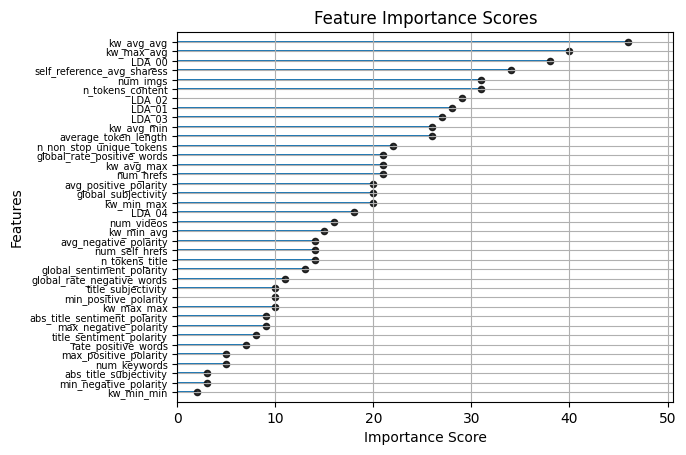

In [ ]:
import xgboost as xgb
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt


# 轉換索引為字串列表
feature_names = X_train.columns.tolist()

# 創建 DMatrix 物件時使用轉換後的特徵名稱
dtrain = xgb.DMatrix(X_train_scaled, label=y_train, feature_names=feature_names)
dtest = xgb.DMatrix(X_test_scaled, label=y_test, feature_names=feature_names)

# 設定模型參數
params = {'max_depth': 3,
          'objective': 'binary:logistic',
          'eval_metric': 'error'
          }

# 訓練模型
num_rounds = 100
bst = xgb.train(params, dtrain, num_rounds)

# 預測
preds_proba = bst.predict(dtest)
preds = np.round(preds_proba)

# 計算準確率
accuracy = accuracy_score(y_test, preds)
print("準確率：", accuracy*100, '%')
print("分類報告：")
print(classification_report(y_test, preds))

# 繪製特徵重要性圖
xgb.plot_importance(bst, importance_type = 'weight', show_values=False)
# 獲取特徵重要性分數
importance = bst.get_score(importance_type = 'weight')

# 提取特徵名稱和對應分數
features = sorted(importance.items(), key = lambda x: x[1], reverse = False)
feature_names = [x[0] for x in features]
scores = [x[1] for x in features]

# 將特徵名稱轉換為索引
feature_indices = range(len(feature_names))

# 將特徵分數以黑點的方式標示在坐標上
plt.scatter(scores, feature_indices, color='black', alpha=0.8, s=20)
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Feature Importance Scores')

# 將 Y 軸的特徵名稱改為原始變數的名稱
plt.yticks(feature_indices, feature_names, fontsize=7)

plt.show()


2. 用全部的特徵去看xgboost的變數重要性

In [ ]:
import xgboost as xgb
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt


# 轉換索引為字串列表
feature_names = X_train_2.columns.tolist()

# 創建 DMatrix 物件時使用轉換後的特徵名稱
dtrain = xgb.DMatrix(X_train_2, label=y_train_2, feature_names=feature_names)
dtest = xgb.DMatrix(X_test_2, label=y_test_2, feature_names=feature_names)

# 設定模型參數
params = {'max_depth': 3,
          'objective': 'binary:logistic',
          'eval_metric': 'error'
          }

# 訓練模型
num_rounds = 100
bst = xgb.train(params, dtrain, num_rounds)

# 預測
preds_proba = bst.predict(dtest)
preds = np.round(preds_proba)

# 計算準確率
accuracy = accuracy_score(y_test_2, preds)
print("準確率：", accuracy*100, '%')
print("分類報告：")
print(classification_report(y_test_2, preds))

feature_importance = bst.get_score(importance_type='weight')
# 提取特徵名稱和對應分數
features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
feature_names = [x[0] for x in features]
scores = [x[1] for x in features]

# 將特徵名稱轉換為索引
feature_indices = range(len(feature_names))

# 繪製特徵重要性
plt.figure(figsize=(10, 6))
plt.barh(feature_names, scores)
plt.xlabel('Feature Importance Score')
plt.yticks(feature_indices, feature_names, fontsize=6)
plt.title('Feature Importance Scores (XGBoost)')
plt.gca().invert_yaxis()  # 反轉 y 軸，讓重要性高的特徵顯示在上面
plt.show()

##### <font color = lightgreen> 跑 GDBT </font>

2. 未標準化

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gbdt = GradientBoostingClassifier(n_estimators = 100, learning_rate = 0.1, max_depth = 3, random_state=42)

gbdt.fit(X_train_scaled, y_train)

y_pred = gbdt.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print("準確率：", accuracy*100, '%')
print("分類報告：")
print(classification_report(y_test, y_pred))


In [ ]:
clean_df.columns

In [ ]:
feature_importance = gbdt.feature_importances_

# 繪製特徵重要性
plt.figure(figsize=(10, 6))
plt.barh(clean_df.columns[0:-3], feature_importance)
plt.ylabel('Feature Index')
plt.xlabel('Feature Importance Score')
plt.title('Feature Importance Scores')
plt.yticks(fontsize=8)
plt.show()